**Xây dựng model Softmax từ đầu**

In [10]:
import torch

class SoftmaxRegressionScratch:
    def __init__(self, input, output, device):
        self.w = torch.randn(size=(input, output), device=device, dtype=torch.float32, requires_grad=True)
        self.b = torch.zeros(output, device=device, requires_grad=True)

    def softmax(self, X):
        # tính e mũ của từng output mô hình linear
        X_exp = torch.exp(X)
        # chuẩn hóa về xác suất
        sum_at_sample = X_exp.sum(axis=1, keepdim=True)
        return X_exp / sum_at_sample

    def forward(self, X):
        #reshape X về dạng có cột = hàng của w
        X = X.reshape((-1, self.w.shape[0]))
        #tính toán lại xác xuất đầu ra của từng nhãn
        return self.softmax(torch.matmul(X, self.w) + self.b)
    
    def cross_entropy(self, y_hat, y):
        return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()
    
    def loss(self, y_hat, y):
        return self.cross_entropy(y_hat, y)
    

    

In [2]:
import torchvision
from torchvision import transforms

trans = torchvision.transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

data_train = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=trans,
    download=True)
data_val = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=trans,
    download=True
)

len(data_train), len(data_val)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.43MB/s]


(60000, 10000)

torch.Size([1, 32, 32]) 5


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

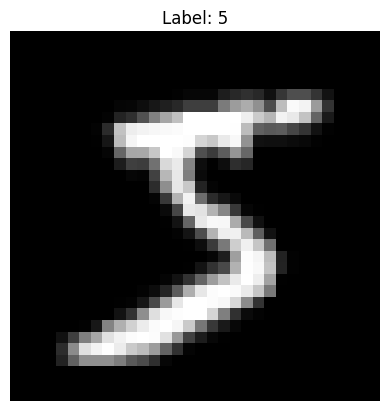

In [3]:
img, label = data_train[0]
print(img.shape, label)

import matplotlib.pyplot as plt

plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')



In [4]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    data_train,
    batch_size=64,
    shuffle=True
)

val_loader = DataLoader(
    data_val,
    batch_size=64,
    shuffle=False
)

In [17]:
# Kiểm tra GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Tạo model và di chuyển sang GPU
model = SoftmaxRegressionScratch(input=1024, output=10, device=device)
model.w = model.w.to(device)
model.b = model.b.to(device)

lr = 0.1
epochs = 50
loss_histoty = {'train': [], 'val': []}

for epoch in range(epochs):
    train_loss_avg = 0
    for X_batch, y_batch in train_loader:
        # Di chuyển batch sang GPU
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        y_hat = model.forward(X_batch)
        loss = model.cross_entropy(y_hat, y_batch)

        if model.w.grad is not None:
            model.w.grad.zero_()
            model.b.grad.zero_()

        loss.backward()

        with torch.no_grad():
            model.w -= lr * model.w.grad
            model.b -= lr * model.b.grad

        train_loss_avg += loss.item()
    train_loss_avg /= len(train_loader)
    loss_histoty['train'].append(train_loss_avg)

    with torch.no_grad():
        val_loss_avg = 0
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            y_hat = model.forward(X_batch)
            loss = model.cross_entropy(y_hat, y_batch)
            val_loss_avg += loss.item()
        val_loss_avg /= len(val_loader)
        loss_histoty['val'].append(val_loss_avg)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss_avg:.4f}")


Using device: cuda
Epoch 1/50, Train Loss: 1.8857, Val Loss: 0.8379
Epoch 2/50, Train Loss: 0.7613, Val Loss: 0.6412
Epoch 3/50, Train Loss: 0.6168, Val Loss: 0.5506
Epoch 4/50, Train Loss: 0.5441, Val Loss: 0.5099
Epoch 5/50, Train Loss: 0.4996, Val Loss: 0.4742
Epoch 6/50, Train Loss: 0.4684, Val Loss: 0.4546
Epoch 7/50, Train Loss: 0.4465, Val Loss: 0.4386
Epoch 8/50, Train Loss: 0.4278, Val Loss: 0.4178
Epoch 9/50, Train Loss: 0.4137, Val Loss: 0.4076
Epoch 10/50, Train Loss: 0.4015, Val Loss: 0.4000
Epoch 11/50, Train Loss: 0.3916, Val Loss: 0.3964
Epoch 12/50, Train Loss: 0.3832, Val Loss: 0.3835
Epoch 13/50, Train Loss: 0.3754, Val Loss: 0.3805
Epoch 14/50, Train Loss: 0.3687, Val Loss: 0.3710
Epoch 15/50, Train Loss: 0.3621, Val Loss: 0.3734
Epoch 16/50, Train Loss: 0.3574, Val Loss: 0.3673
Epoch 17/50, Train Loss: 0.3526, Val Loss: 0.3619
Epoch 18/50, Train Loss: 0.3474, Val Loss: 0.3567
Epoch 19/50, Train Loss: 0.3442, Val Loss: 0.3516
Epoch 20/50, Train Loss: 0.3402, Val Los

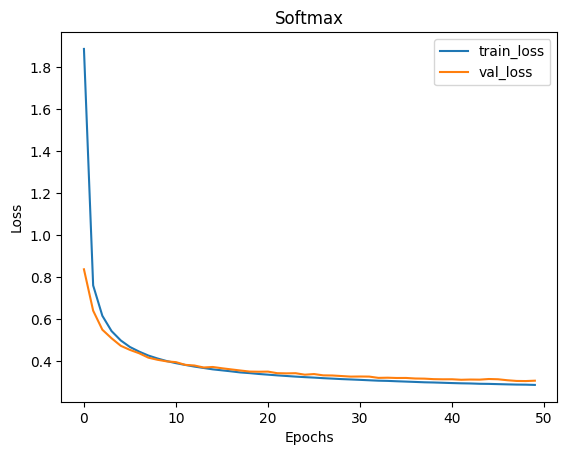

In [18]:
from matplotlib import pyplot as plt

plt.plot(loss_histoty['train'], label='train_loss')
plt.plot(loss_histoty['val'], label='val_loss')
plt.title('Softmax')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [21]:
from sklearn.metrics import classification_report

# Tính toán predictions trên tất cả validation data
y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        y_hat = model.forward(X_batch)
        predictions = y_hat.argmax(dim=1).cpu().numpy()
        
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predictions)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.97      0.97      1135
           2       0.92      0.90      0.91      1032
           3       0.88      0.91      0.90      1010
           4       0.91      0.93      0.92       982
           5       0.86      0.87      0.86       892
           6       0.94      0.93      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.90      0.85      0.87       974
           9       0.91      0.89      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



**Xây dựng Softmax bằng thư viện**

In [32]:
from torch import nn, optim

class SoftmaxRegression(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.net = nn.Sequential(nn.Flatten(),nn.Linear(input, output))
    
    def forward(self, X):
        return self.net(X)
    
model = SoftmaxRegression(1024, 10)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(params=model.parameters(), lr=0.1, weight_decay=0.01)

epochs = 4

loss_histoty_nn = {"train": [], "val": []}

for epoch in range(epochs):
    train_loss = 0
    for X_batch, y_batch in train_loader:
        y_hat = model(X_batch)

        loss = criterion(y_hat, y_batch)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_loss += loss.item()
    train_loss_avg = train_loss / len(train_loader)
    loss_histoty_nn["train"].append(train_loss_avg)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_hat = model(X_batch)
            loss = criterion(y_hat, y_batch)
            val_loss += loss.item()
        
        val_loss_avg = val_loss / len(val_loader)
        loss_histoty_nn["val"].append(val_loss_avg)
    print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss_avg}, Val Loss: {val_loss_avg}")



Epoch 1/4: Train Loss: 0.4974063841391728, Val Loss: 0.386838418473104
Epoch 2/4: Train Loss: 0.40355990456937474, Val Loss: 0.37810071780803095
Epoch 3/4: Train Loss: 0.39939970818600423, Val Loss: 0.3951294005486616
Epoch 4/4: Train Loss: 0.39951671373996656, Val Loss: 0.3747642164349936


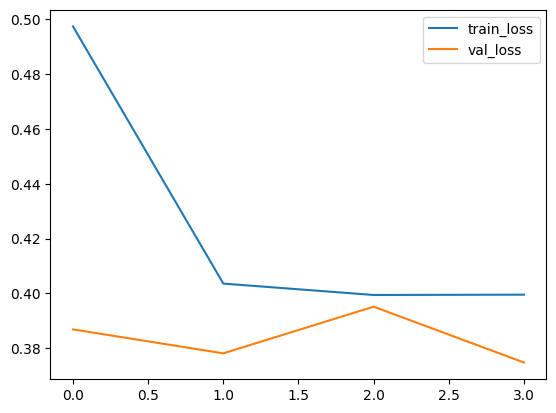

In [33]:
from matplotlib import pyplot as plt

plt.plot(loss_histoty_nn["train"], label='train_loss')
plt.plot(loss_histoty_nn["val"], label = 'val_loss')
plt.legend()
plt.show()

In [34]:
from sklearn.metrics import classification_report

# Tính toán predictions trên tất cả validation data
y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        
        y_hat = model.forward(X_batch)
        predictions = y_hat.argmax(dim=1)
        
        y_true.extend(y_batch)
        y_pred.extend(predictions)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       980
           1       0.94      0.98      0.96      1135
           2       0.93      0.86      0.89      1032
           3       0.88      0.91      0.89      1010
           4       0.92      0.90      0.91       982
           5       0.91      0.84      0.87       892
           6       0.92      0.94      0.93       958
           7       0.93      0.90      0.91      1028
           8       0.85      0.87      0.86       974
           9       0.88      0.89      0.88      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

